Project Objective : Define a structure for predictive modelling projects

## Problem Statement :
Need to classify students who fail(DFW grades) or pass
## Dataset :
Pre Survey information, Demographics etc for students in last three years who have taken courses of interest
## Approach :
### Steps 
1. Importing all required Libraries
2. Reading & Cleaning Dataset
3. Converting categorical variables to numeric variables
4. Train-test split
5. Nested cross validation with grid search
6. Final test score with the selected classification model


In [4]:
%matplotlib inline
##pandas,numpy 
import numpy as np
import pandas as pd

## for plotting 
import matplotlib.pyplot as plt

##for datetime functions
from datetime import datetime
from dateutil.parser import parse

## for different classification algorithms
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import sklearn
import warnings
warnings.filterwarnings("ignore")


In [5]:
sklearn.__version__

'0.20.2'

### 2. Reading & Cleaning Dataset

In [7]:
## change location based on data 
data1 = pd.read_csv("{File Location}")


In [1]:
#view the data
data1.head()

In [8]:
#Adding new columns - pass/fail column
data1.columns


In [6]:
pd.unique(data1["CRSE_GRADE_OFF"])
#data1.loc[:,["CRSE_GRADE_OFF","DFW"]]

array(['C', 'F', 'S', 'A', 'W', 'B-', 'C+', 'D+', 'A-', 'C-', 'B', 'B+',
       'D', 'N', 'I'], dtype=object)

In [7]:
## Seeting DFW target column
data1["DFW"]= np.where(data1['CRSE_GRADE_OFF'].isin(['D','F','W','I','N']), '1', '0')

In [8]:
## New columns for final time and scores
##Converting NaNs to 0
#data1["TIME_1"].fillna(0)
data1 = data1.replace(r'\s+', np.nan, regex=True)

In [9]:
data1["time"] = data1["TIME"].fillna(0) + data1["TIME_1"].fillna(0)
data1["INITIAL_TIME"]= data1["INITIAL_TIME"].fillna(0) 
data1["INITIAL_SCORE"] =data1["INITIAL_SCORE"].fillna(0) 
#pd.unique(data1["INITIAL_TIME_1"]) and score_ 1 are only Nan

In [10]:
newData = data1.loc[:,[<all required columns>]]


### 3. Converting categorical variables to numeric variables

In [11]:
## converting categorical features into dummy variables
#newData_Selected = newData
#getting categorical features
#cat_features = [col for col in newData_Selected.columns if col not in newData_Selected.select_dtypes(['int64','float64']).columns ] 
#numeric_features = [col for col in newData_Selected.columns if col in (newData_Selected.select_dtypes(['int64','float64']) ).columns ] 

numeric_features = [<all numerical features>]
cat_features =[<all categorical features>]

In [ ]:
##convert categorical into numerical value
for feat in cat_features:
    newData.loc[:,feat] = newData.loc[:,feat].astype("category").cat.codes
newData = newData.fillna(0)
#newData.sample(5)

In [15]:
newData = newData.convert_objects(convert_numeric=True)

### 4. Train-test split

In [16]:
#Splitting data into test(20%) & train (80%)
y = np.asarray(newData.loc[:,"DFW"])
x = newData.loc[:, newData.columns != "DFW"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(43626, 17) (18698, 17)


### 5. Nested cross validation with grid search

We want to build different models and compare different algorithms (XGBoost vs. logistic regression vs. Random Forests)
Therefore, we are using nested cross-validation. In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model via k-fold cross-validation on the training fold. After model selection, the test fold is then used to evaluate the model performance. After we have identified our “favorite” algorithm, we can follow-up with a “regular” k-fold cross-validation approach (on the complete training set) to find its “optimal” hyperparameters and evaluate it on the independent test set.

In [39]:
##Logistic Regression
from sklearn.linear_model import LogisticRegression

# Set the parameters by cross-validation
# logistic regression
tuned_parameters = {"C":np.logspace(-5,6), "penalty":["l1","l2"]}



NUM_TRIALS = 5;

nested_scores= np.zeros(NUM_TRIALS)
for i in range(NUM_TRIALS):
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_linear = GridSearchCV(estimator = LogisticRegression(), param_grid=tuned_parameters, cv=inner_cv, scoring = 'accuracy')
    clf_linear.fit(X_train,y_train)


# Nested CV with parameter optimization
    nested_score = cross_val_score(clf_linear, X_train,y_train, cv=outer_cv,scoring='accuracy')
    nested_scores[i] = nested_score.mean()
    
print(clf_linear.estimator)
print(nested_scores)
print("Average scores of {0:6f} with std. dev. of {1:6f}.".format(nested_scores.mean(), nested_scores.std()))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[0.87234674 0.87214057 0.87230089 0.87273643 0.87236967]
Average scores of 0.872379 with std. dev. of 0.000196.


In [34]:
## XGBoost
from xgboost import XGBClassifier

# Set the parameters by cross-validation

tuned_parameters = {"objective": ["binary:logistic"],
          "booster": ["gbtree"],
          "learning_rate": [0.02],
          "max_depth": [5],
          "min_child_weight": [5]}
num_boost_round = 1000



NUM_TRIALS = 5;

nested_scores= np.zeros(NUM_TRIALS)
for i in range(NUM_TRIALS):
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_xgB = GridSearchCV(estimator = XGBClassifier(num_boost_round), param_grid=tuned_parameters, cv=inner_cv, scoring = 'accuracy')
    clf_xgB.fit(X_train,y_train)


# Nested CV with parameter optimization
    nested_score = cross_val_score(clf_xgB,X_train,y_train, cv=outer_cv,scoring='accuracy')
    nested_scores[i] = nested_score.mean()
    
print(clf_xgB.estimator)
print(nested_scores)
print("Average scores of {0:6f} with std. dev. of {1:6f}.".format(nested_scores.mean(), nested_scores.std()))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1000, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
[0.88066753 0.88124063 0.88135507 0.8815156  0.88078218]
Average scores of 0.881112 with std. dev. of 0.000330.


In [18]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier

n_estimators = [10, 50]
max_depth = [10, 20]

tuned_parameters=dict(n_estimators=n_estimators,max_depth = max_depth)

NUM_TRIALS = 5;

nested_scores= np.zeros(NUM_TRIALS)
for i in range(NUM_TRIALS):
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid=tuned_parameters, cv=inner_cv, scoring = 'accuracy')
    clf_rf.fit(X_train,y_train)


# Nested CV with parameter optimization
    nested_score = cross_val_score(clf_rf,X_train,y_train, cv=outer_cv,scoring='accuracy')
    nested_scores[i] = nested_score.mean()
    
print(clf_rf.estimator)
print(nested_scores)
print("Average scores of {0:6f} with std. dev. of {1:6f}.".format(nested_scores.mean(), nested_scores.std()))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[0.99420069 0.99557604 0.99406317 0.99546141 0.99518638]
Average scores of 0.994898 with std. dev. of 0.000639.


In [19]:
### Feature Importance
### reference https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(clf_rf.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances


,importance
time,0.130219
INITIAL_TIME,0.120178
CHEM_SCORE,0.104903
INITIAL_SCORE,0.095930
COMP_ACT_SCORE,0.092835
TOT_TRNSFR,0.090057
HS_RANK_PCT,0.073392
CATALOG_NBR,0.070616
INSTRUCTION_MODE,0.039446
ACAD_PROG_SDESC,0.036686


## 6. Final test score with the selected classification model

Since Random Forest gave best accuracy, we use a k-fold cross-validation approach on the complete training set to find its optimal hyperparameters and evaluate it on the independent test set.

In [20]:
## Cross validation  ## After model selection
sclf = RandomForestClassifier()
n_estimators = [10, 50]
max_depth = [10, 20]

tuned_parameters=dict(n_estimators=n_estimators,max_depth = max_depth)

clf_final = GridSearchCV(estimator=RandomForestClassifier(), param_grid=tuned_parameters, cv=5)
model = clf_final.fit(X_train,y_train)
be = clf_final.best_estimator_
#fitting it on train data 
be.fit(X_train,y_train)
#predicting on test data 
y_true, y_pred = y_test, be.predict(X_test)
# finding accuracy  
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy :", test_accuracy)
#model details
print("Model Used :",be)


Test Accuracy : 0.9977002888009413
Model Used : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [21]:
### Feature Importance
### reference https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances_test = pd.DataFrame(clf_final.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_test


,importance
time,0.133469
INITIAL_TIME,0.118352
CHEM_SCORE,0.108135
COMP_ACT_SCORE,0.093234
INITIAL_SCORE,0.092719
TOT_TRNSFR,0.090548
HS_RANK_PCT,0.072847
CATALOG_NBR,0.071745
INSTRUCTION_MODE,0.036915
ACAD_PROG_SDESC,0.036081


## A Random Forest  model can identify whether students will be retained or not with ~99.79% accuracy

In [37]:
### Checking for overfitting

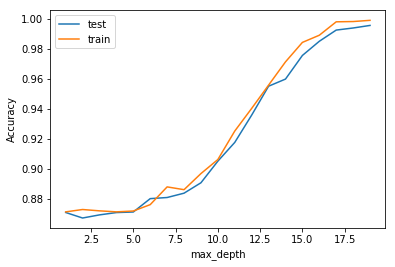

In [38]:
# Optimize decision tree and detect (potential) over-fitting
# I will try maximum depths from 1 to 10
complexity_values = range(1,50)

# I need an empty list to hold my accuracies
train_accuracies = []
test_accuracies=[]

# I will go through each complexity_value one at a time.
for complexity_value in complexity_values:
    # This will create an empty tree with a specific maximum depth (complexity)
    clf = RandomForestClassifier(criterion="gini", max_depth=complexity_value)
    #clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=complexity_value,max_leaf_nodes  =2)
    #clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=complexity_value,min_impurity_decrease=0.5)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    test_accuracies.append(clf.fit(X_train, y_train).score(X_test, y_test))
    train_accuracies.append(clf.fit(X_train, y_train).score(X_train, y_train))
    
# We want to plot our results
line1, =plt.plot(complexity_values, test_accuracies,label='test_accuracies')
line2, =plt.plot(complexity_values, train_accuracies,label='train_accuracies')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend((line1, line2), ('test', 'train'))
plt.show()